In [1]:
#do this later from admin: !python -m pip install --upgrade pip


# TOC

Should have:
1. ETL
2. EDA
3. Feature Engineering - Permanent
4. Modeling - Pure Regression
5. Modeling - Pure classification
6. Modeling - combination


Find centroids on train, predict test centroids

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [Feature Engineering](#2.0-bullet)  
 2.1 [Pt 1 - Regression](#2.1-bullet)  
 2.2 [Pt 2 - Classification](#2.2-bullet)
3. [Basic Model](#3.0-bullet)  
 3.1 [Pt 1 - Regression](#3.1-bullet)  
 3.2 [Pt 2 - Classification](#3.2-bullet)
4. [Reference and Planning](#4.0-bullet)

# Do not Run All cells - lots of charts

In [40]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
import requests
import json

#Youtube Data API Packages: 
"""from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
from googleapiclient.discovery import build
import argparse
from googleapiclient.errors import HttpError"""

#Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import r2_score,confusion_matrix, roc_auc_score, roc_curve

#NLP & Text Management
# from sklearn.feature_extraction import stop_words
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# import re
# from textblob import TextBlob
# from wordcloud import WordCloud
# from nltk.stem import PorterStemmer

#Time analysis
import time
import datetime
# from statsmodels.tsa.stattools import pacf
# from statsmodels.graphics.tsaplots import plot_pacf

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('classic')
sns.set_style('whitegrid')

In [2]:
df_main = pd.read_csv('./data/engineered_data/data_engineered_10.9_2019.csv')

In [5]:
model_time = ['is_weekend', 'is_friday', 'year_day', 'week', 'week_day', 'month', 'month_day', 'year',  ]
model_text = ['description_sentiment', 'description_wordcount',
  'tags_sentiment', 'tags_wordcount', 'title_sentiment',
 'title_wordcount', 'title_featuring', 'title_length', ]
model_title_letter = ['intitle_a',  'intitle_b', 'intitle_c', 'intitle_d', 'intitle_e', 'intitle_f', 'intitle_g',
 'intitle_h', 'intitle_i', 'intitle_j', 'intitle_k', 'intitle_l', 'intitle_m', 'intitle_n', 'intitle_o',
 'intitle_p', 'intitle_q', 'intitle_r', 'intitle_s', 'intitle_t', 'intitle_u', 'intitle_v', 'intitle_w',
 'intitle_x', 'intitle_y', 'intitle_z',]              
model_ratios = ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio',]
model_other = ['duration', 'contentRating', 'regionRestriction',  'licensedContent', 'caption', 'definition']
measures = ['likeCount', 'dislikeCount', 'commentCount', 'viewCount',
            'view_log',  'comment_log',  'like_log', 'dislike_log', 
            'view_class' ]
non_model_cols = ['request_token', 'letter_search','channelTitle', 'tags', 'title', 'vidId','publishedAt','favoriteCount',
              'description','defaultLanguage', ]

# <a class="anchor" id="3.0-bullet"> 3. Basic Model</a>

In [106]:
df_formodel = df_main

In [170]:
df_description = pd.read_csv('./data/engineered_data/description_wordvec.csv')
df_tag = pd.read_csv('./data/engineered_data/tag_wordvec.csv')
df_title = pd.read_csv('./data/engineered_data/title_wordvec.csv')
df_combined = df_description.join(df_tag.set_index('vidId'), on=df_description['vidId'], how='left', rsuffix='tag')
df_combined = df_combined.join(df_title.set_index('vidId'), on=df_combined['vidId'], how='left', rsuffix='title')

cols_exclude_text = [col for col in df_combined.columns if '_word_' not in str(col)]
cols_include_initial_text = [col for col in df_combined.columns if col not in cols_exclude]

df_formodel = df_main.join(df_combined.set_index('vidId'), on=df_main['vidId'], how='left', rsuffix='text_combo')

In [171]:
[col for col in df_main.columns if 'ratio' in col]

['duration', 'lv_ratio', 'comment_view_ratio', 'like_dislike_ratio']

In [172]:
cols_alphabet = ['intitle_a', 'intitle_d', 'intitle_f', 'intitle_g', 'intitle_i', 
                 'intitle_k', 'intitle_l','intitle_p','intitle_v','intitle_x','intitle_y' ]
cols_exclude = ['year_day', 'month', 'vidId', 
                'titletext_combo', 'tagstext_combo', 'descriptiontext_combo', 'description', 'tags', 'title', 'view_log', 
               'view_logtitle', 'view_logtag', 'Unnamed: 0title', 'Unnamed: 0']
#'tags_sentiment','title_sentiment', 'title_wordcount' 

cols_include_initial = [col for col in df_formodel.columns if \
(col in model_time or \
col in model_text or \
col in cols_alphabet or \
col in model_ratios or \
col in model_other ) and \
col not in cols_exclude]
"""or \
col in cols_include_initial_text"""

#'lv_ratio','comment_view_ratio' take this between .85 and .9
df_formodel = df_formodel[df_formodel['view_class']>1]

In [173]:
y = df_formodel.view_class
X = df_formodel.loc[:, cols_include_initial]
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=30)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [109]:
y.isnull().sum()

0

## <a class="anchor" id="3.1-bullet">3.1 Unsupervised Learning</a>



### KMeans

In [174]:
uns_X = df_formodel.loc[:, cols_include_initial+['view_class']]

ss2 = StandardScaler()
uns_X_sc = ss.fit_transform(uns_X)

In [175]:
from sklearn.cluster import DBSCAN, KMeans

In [176]:
from sklearn.metrics import silhouette_score

In [177]:
for n in range(3, 11):
    classifier = KMeans(n_clusters=n)
    classifier.fit_predict(X=uns_X_sc)
    print('   n: ', n, ' score: ', classifier.inertia_)


   n:  3  score:  258976.94672131332
   n:  4  score:  248781.3687853264
   n:  5  score:  240224.05235717952
   n:  6  score:  233631.48239741093
   n:  7  score:  226990.0802880939
   n:  8  score:  222466.1960529029
   n:  9  score:  217129.58473626763
   n:  10  score:  213447.81148673507


In [126]:
for i in range(30, 50):
    classifier = KMeans(n_clusters=25, random_state=i)
    df_classified = df_main.join(pd.DataFrame(pd.Series(classifier.fit_predict(X=uns_X_sc)), columns=['kclass']))
    print('    i: ', i, ' max: ', df_classified.loc[:, ['kclass', 'view_log']].groupby('kclass').mean().max())

    i:  30  max:  view_log    6.546026
dtype: float64
    i:  31  max:  view_log    6.568186
dtype: float64
    i:  32  max:  view_log    6.549206
dtype: float64
    i:  33  max:  view_log    6.581191
dtype: float64
    i:  34  max:  view_log    6.553523
dtype: float64
    i:  35  max:  view_log    6.581191
dtype: float64
    i:  36  max:  view_log    6.568186
dtype: float64
    i:  37  max:  view_log    6.568186
dtype: float64
    i:  38  max:  view_log    6.568186
dtype: float64
    i:  39  max:  view_log    6.568186
dtype: float64
    i:  40  max:  view_log    6.568186
dtype: float64
    i:  41  max:  view_log    6.44031
dtype: float64
    i:  42  max:  view_log    6.536831
dtype: float64
    i:  43  max:  view_log    6.47426
dtype: float64
    i:  44  max:  view_log    6.487877
dtype: float64
    i:  45  max:  view_log    6.536831
dtype: float64
    i:  46  max:  view_log    6.581191
dtype: float64
    i:  47  max:  view_log    6.47114
dtype: float64
    i:  48  max:  view_log    6

In [178]:
classifier = KMeans(n_clusters=8, random_state=43)
df_classified = df_main.join(pd.DataFrame(pd.Series(classifier.fit_predict(X=uns_X_sc)), columns=['kclass']))

In [179]:
df_classified[df_classified.title.str.contains('Despacito')].loc[:, ['title', 'viewCount', 'kclass']]

,title,viewCount,kclass
3270,Luis Fonsi - Despacito ( cover by J.Fla ),127411039,7.0
7479,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,1.0
7594,"Luis Fonsi, Daddy Yankee - Despacito (Remix Au...",633857377,5.0


In [189]:
for i in range(9):
     print('   ', i, df_classified[df_classified.kclass==i].shape[0])

    0 997
    1 1440
    2 1224
    3 1927
    4 589
    5 1050
    6 17
    7 1358
    8 0


In [190]:
df_classified.std() / df_classified.mean()

caption                   3.483436
commentCount              5.710380
definition                0.658243
dislikeCount              7.359757
duration                  2.627418
favoriteCount                  NaN
licensedContent           0.852121
likeCount                 3.361724
regionRestriction         2.605975
viewCount                 3.845415
contentRating            22.593594
year                      0.239841
month                     0.483853
month_day                 0.538086
year_day                  0.524002
week_day                  0.656964
view_log                  0.266202
comment_log               0.491606
like_log                  0.383135
dislike_log               0.551699
view_class                0.293376
week                      0.516395
description_sentiment     1.827508
description_wordcount     1.367966
tags_sentiment            3.380355
tags_wordcount            0.856608
title_sentiment           5.362453
title_wordcount           0.469499
title_featuring     

It looks like the cutoff should be somewhere around 8.5 for view log

In [26]:
df_main[df_main.view_log>8.5].shape

(337, 70)

In [134]:
df_classified.groupby('kclass').mean().std().sort_values()

favoriteCount            0.000000e+00
contentRating            4.089615e-03
title_sentiment          1.674895e-02
intitle_q                1.829676e-02
tags_sentiment           1.834269e-02
lv_ratio                 2.321357e-02
comment_view_ratio       2.477155e-02
description_sentiment    2.608703e-02
caption                  3.277385e-02
intitle_j                3.297021e-02
title_featuring          3.508933e-02
regionRestriction        3.664481e-02
is_friday                3.920021e-02
is_weekend               4.594237e-02
intitle_z                4.936614e-02
intitle_x                5.049607e-02
intitle_b                5.142826e-02
intitle_w                5.263046e-02
intitle_v                5.427701e-02
definition               5.774341e-02
licensedContent          6.249108e-02
intitle_y                7.156791e-02
intitle_p                7.375208e-02
intitle_m                8.163824e-02
intitle_g                8.191738e-02
intitle_k                8.364927e-02
intitle_u   

In [144]:
#df_classified.to_csv('./data/k_classified_data.csv', index=False)

### DBScan

In [137]:
db_model = DBSCAN(eps=5)

pd.DataFrame(db_model.fit_predict(uns_X_sc), columns=['class'])['class'].value_counts()

 0    8250
-1     352
Name: class, dtype: int64

In [138]:
db_preds = db_model.fit_predict(uns_X_sc)
df_db_classes = df_main[df_main.view_class>1]

In [139]:
df_db_classes['db_class'] = db_preds

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [142]:
df_db_classes[df_db_classes.db_class==-1].view_log.mean()

5.770894846454698

## <a class="anchor" id="3.2-bullet">3.2 Supervised Classification</a>



### 3.2.1 Classification - Gradient Boost

In [155]:
gb = GradientBoostingClassifier()
gb.fit(X_train_sc, y_train)

preds = gb.predict(X_test_sc)

In [156]:
cm = confusion_matrix(y_test, preds)
pd.DataFrame(cm, columns=range(2,10), index=range(2,10))

,2,3,4,5,6,7,8,9
2,34,12,4,12,44,2,0,0
3,11,21,16,23,65,7,0,0
4,9,20,22,42,80,16,0,0
5,7,5,17,81,181,49,1,0
6,11,5,11,84,287,189,12,0
7,2,3,2,20,199,294,21,1
8,1,0,0,6,45,128,33,0
9,0,0,0,0,1,11,4,0


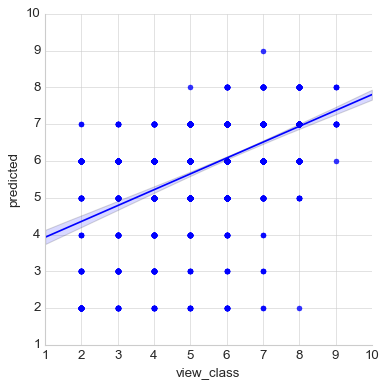

In [157]:
df_residuals = pd.DataFrame(y_test)
df_residuals['predicted'] = preds
df_residuals['residuals'] = df_residuals.predicted - df_residuals.view_class
sns.lmplot('view_class', 'predicted', data=df_residuals)

In [158]:
r2_score(df_residuals.view_class, df_residuals.predicted)


0.23393125202470566

In [34]:
df_big = df_main[df_main.viewCount > 100000000]
df_big_ss = ss.transform(df_big.loc[:, cols_include_initial])

df_big['predicted'] = 10**model.predict(df_big_ss)

#df_big.viewCount = df_big.viewCount.map(lambda x: '{:.6g}'.format(x))

df_big.loc[:, ['title', 'viewCount', 'predicted']].sort_values(by='viewCount', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,title,viewCount,predicted
7479,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,1000000000
4268,Ed Sheeran - Shape of You [Official Video],3827104659,1000000000
7190,Wiz Khalifa - See You Again ft. Charlie Puth [...,3788737518,1000000000
5540,Mark Ronson - Uptown Funk ft. Bruno Mars,3256917992,1000000000
3634,PSY - GANGNAM STYLE(강남스타일) M/V,3218413082,1000000000
569,Justin Bieber - Sorry (PURPOSE : The Movement),3014897224,1000000000
7417,Maroon 5 - Sugar,2756205542,1000000000
7514,Taylor Swift - Shake It Off,2650920924,1000000000
5506,Katy Perry - Roar (Official),2638406673,1000000000
627,Enrique Iglesias - Bailando (Español) ft. Desc...,2582945265,100000000


## <a class="anchor" id="3.2-bullet">3.2 KClass binary</a>



In [159]:
y=1*(df_formodel.view_log>8)
X = df_formodel.loc[:, cols_include_initial]

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=25)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [160]:
gb_bin = GradientBoostingClassifier()
gb_bin.fit(X_train_sc, y_train)
gb_bin.score(X_test_sc, y_test)

0.897721989772199

In [161]:
preds = gb_bin.predict_proba(X_test_sc)
print('    accuracy: ', gb_bin.score(X_test_sc, y_test), 'roc: ', roc_auc_score(y_test, [element[1] for element in preds]))

    accuracy:  0.897721989772199 roc:  0.8452105819288909


In [162]:
cm = confusion_matrix(y_test, gb_bin.predict(X_test_sc))
pd.DataFrame(cm)

,0,1
0,1912,25
1,195,19


In [146]:
df_main[df_main.view_log>8].shape

(900, 70)

## <a class="anchor" id="3.3-bullet">3.3 Neural Net</a>



In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [46]:
y = df_formodel.view_class
X = df_formodel.loc[:, cols_include_initial]
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=30)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [47]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [61]:
model = Sequential()
#this does input and first activation
model.add(Dense(X_train_sc.shape[1], activation='relu', input_dim=X_train_sc.shape[1]))
model.add(Dropout(.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))

model.add(Dense(y_train_cat.shape[1], activation='softmax')) #1 neuron
model.compile(loss='categorical_crossentropy', optimizer='adam')

history = model.fit(X_train_sc, y_train_cat, validation_data=(X_test_sc, y_test_cat), epochs=100, verbose=0)
preds = model.predict(X_test_sc)
#print( 'score: ', r2_score(y_test, preds))

In [62]:
preds_cat = []
for i in range(len(preds)):
    preds_cat.append(list(preds[i]).index(max(preds[i])))

In [63]:
len(preds_cat)

2151

In [64]:
temp = pd.DataFrame([y_test]).T.reset_index().drop('index', axis=1)
temp['predicted'] = preds_cat

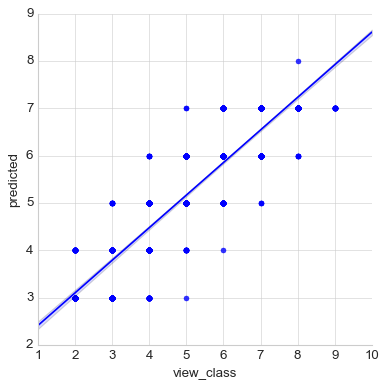

In [65]:
sns.lmplot('view_class', 'predicted', data=temp)

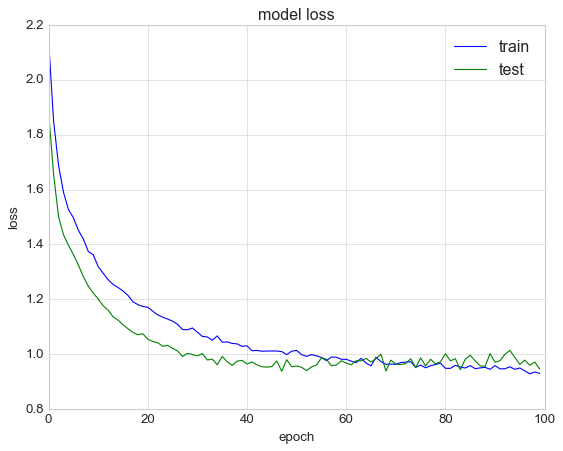

In [66]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

In [55]:
#Save point 1
#df_new.to_csv('./data/alphabet_pull_init_01.10.18.csv', index=False)

In [ ]:
#nope: AdaBoostRegressor, 

## <a class="anchor" id="3.2-bullet">3.2 Interpretation and Advanced Cleaning</a>


# <a class="anchor" id="4.0-bullet"> 4.0 Reference and Planning</a>